In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import warnings
warnings.filterwarnings("ignore")

# Scikit-learn
from sklearn.model_selection import train_test_split

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten,Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam



In [9]:
# 1. Install kagglehub
!pip install kagglehub
import kagglehub

# 2. Download the dataset
path = kagglehub.dataset_download("wjybuqi/traffic-sign-classification-and-recognition")

print("Dataset downloaded to:", path)

!rm -rf /content/traffic-sign-classification-and-recognition


Dataset downloaded to: /kaggle/input/traffic-sign-classification-and-recognition


In [10]:
import shutil

# Original dataset path (from KaggleHub cache)
src = "/root/.cache/kagglehub/datasets/wjybuqi/traffic-sign-classification-and-recognition/versions/1"

# Destination path (cleaner name in Colab Files)
dst = "/content/traffic_sign_dataset"

# ✅ Copy fresh dataset
shutil.copytree(src, dst, dirs_exist_ok=True)

print("Copied dataset to:", dst)


Copied dataset to: /content/traffic_sign_dataset


In [11]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=False,
    rescale=1./255
)


In [12]:
train_ds=tf.keras.utils.image_dataset_from_directory(
    directory="/content/traffic_sign_dataset/test_dataset/test",
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(64,64)
)

validation_ds=tf.keras.utils.image_dataset_from_directory(
    directory="/content/traffic_sign_dataset/train_dataset/train",
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(64,64)
)


Found 324 files belonging to 10 classes.
Found 6024 files belonging to 10 classes.


In [13]:
def process(image,label):
    image=tf.cast(image/255,tf.float32)
    return image,label
train_ds=train_ds.map(process)
validation_ds=validation_ds.map(process)



In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(64,64,3),kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu',kernel_regularizer=regularizers.l2(0.0005)),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu',kernel_regularizer=regularizers.l2(0.0005)),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0005)),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(10, activation='softmax')
])


In [15]:
opt = Adam(learning_rate=1e-3)
model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                 patience=3,
                                 factor=0.5,
                                 min_lr=1e-5)

In [16]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=100,
    callbacks=[lr_reduction]
)


Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 730ms/step - accuracy: 0.3743 - loss: 2.1382 - val_accuracy: 0.5324 - val_loss: 1.6961 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 265ms/step - accuracy: 0.5021 - loss: 1.7259 - val_accuracy: 0.5729 - val_loss: 1.4613 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.5450 - loss: 1.5473 - val_accuracy: 0.5847 - val_loss: 1.2360 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 268ms/step - accuracy: 0.5479 - loss: 1.4243 - val_accuracy: 0.6497 - val_loss: 1.0893 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - accuracy: 0.6329 - loss: 1.1473 - val_accuracy: 0.7170 - val_loss: 0.9881 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 267ms/step - accuracy: 0.6487 - loss: 1.0678 - val_accuracy: 0.7374 - val_loss: 0.9700 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - accuracy: 0.7175 - loss: 1

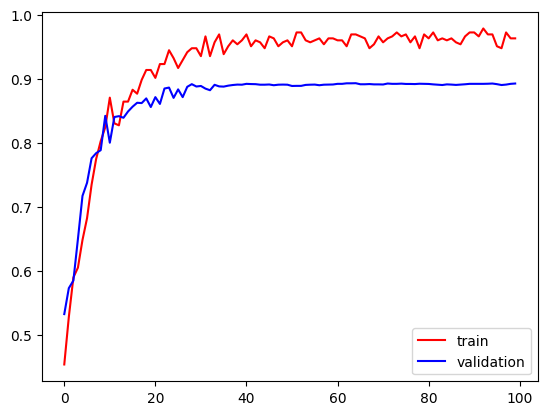

In [17]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

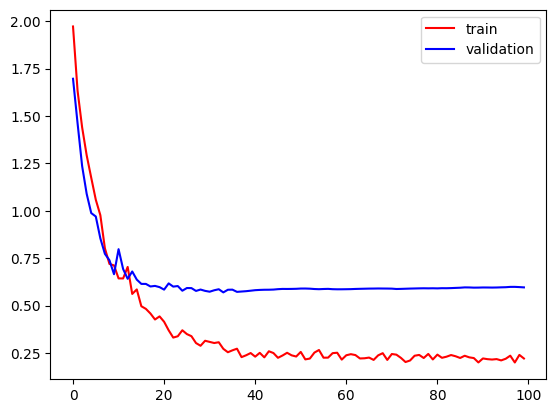

In [18]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [21]:
loss, acc = model.evaluate(train_ds)
print("✅ Test Accuracy:", acc)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9803 - loss: 0.1573
✅ Test Accuracy: 0.9753086566925049


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


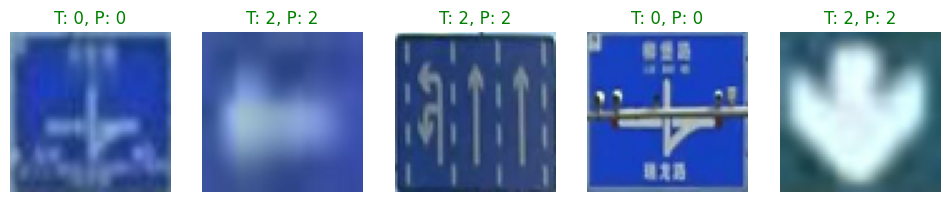

In [25]:
for images, labels in train_ds.take(1):
    y_pred = model.predict(images)
    y_pred_classes = np.argmax(y_pred, axis=1)

    plt.figure(figsize=(12, 4))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i].numpy())
        true_label = labels[i].numpy()
        pred_label = y_pred_classes[i]
        color = "green" if true_label == pred_label else "red"
        plt.title(f"T: {true_label}, P: {pred_label}",color=color)
        plt.axis("off")
    plt.show()
